# Завдання

*Завдання 1: Завантажте MNIST. Розбийте його на навчальну, валідаційну та тренувальну вибірку. Застосуйте PCA для зменшення розмірності.*

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
import pandas as pd

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [3]:
X.shape

(70000, 784)

In [4]:
X_train, X_val, X_test = X[:50000], X[50000:60000], X[60000:]
y_train, y_val, y_test = y[:50000], y[50000:60000], y[60000:]

In [5]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [6]:
pca.n_components_

np.int64(154)

In [7]:
pca.explained_variance_ratio_.sum()

np.float64(0.9502219555521432)

In [8]:
print(X_train_pca.shape[1], X_val_pca.shape[1], X_test_pca.shape[1])

154 154 154


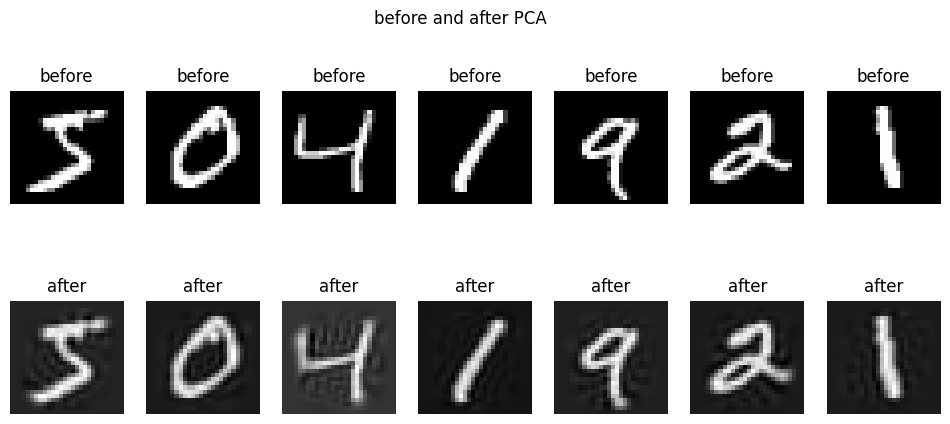

In [9]:
n_samples = 7
X_reconstructed = pca.inverse_transform(X_train_pca[:n_samples])

plt.figure(figsize=(12,5))
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title("before")

    plt.subplot(2, n_samples, n_samples+i+1)
    plt.imshow(X_reconstructed[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title("after")

plt.suptitle("before and after PCA")
plt.show()

Як і на практичному занятті, при зменшенні розмірності сету даних із збереженням 95% дисперсії отримали сет із 154 компонентами.

*Завдання 2: Кластеризуйте датасет, використовуючи K-Means. Знайдіть оптимальну кількість кластерів*

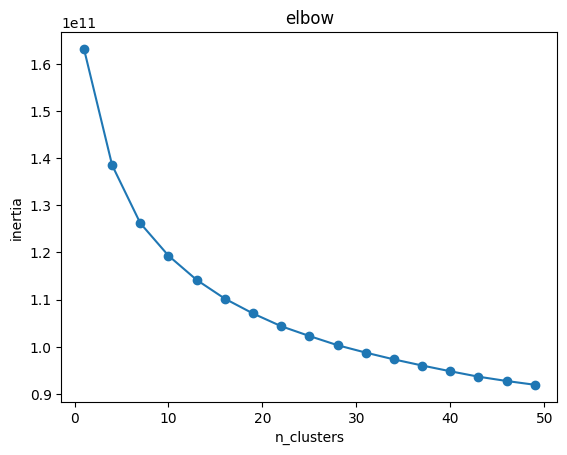

In [10]:
clusters = range(1, 50, 3)
kmeans_per_clusters = [KMeans(random_state=42, n_clusters=n, n_init=10).fit(X_train_pca)
                for n in clusters]
inertias = [model.inertia_ for model in kmeans_per_clusters]

plt.plot(clusters, inertias, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.title('elbow')
plt.show()

З отриманого графіка можна припустити, що найкращим `n_clusters` буде 10, оскільки до цього значення графік спадав швидко, а після - повільніше, а також у сеті є лише цифри від 0 до 9, то `n_clusters`=10 було б логічним значенням к-сті кластерів.

In [11]:
kmeans10 = KMeans(random_state=42, n_clusters=10, n_init=10).fit(X_train_pca)
kmeans10

,n_clusters,10
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [12]:
test_labels = kmeans10.predict(X_test_pca)
test_labels

array([9, 0, 6, ..., 9, 7, 5], shape=(10000,), dtype=int32)

In [13]:
crosstab = pd.crosstab(y_test, test_labels,
                       rownames=['true label'],
                       colnames=["cluster label"])
print(crosstab)

cluster label    0    1    2    3    4    5    6    7    8    9
true label                                                     
0               56    2    4    0   14   43    5   74  780    2
1                3    0    0  666    0    2  463    1    0    0
2               79    9  708   49   36   21   85   23   13    9
3              693   20   39   60    6    9    5  166    4    8
4                0  307    3   17  358   25   27    1    0  244
5              300   50    5   21   29   23   91  317    5   51
6                1    2   10   24  131  734   19   21   16    0
7                0  413   12   36   71    1   48    1    1  445
8              259   46    6   33   18   10   48  512    7   35
9                7  492    2   15  217    2    7   13    7  247


У цій таблиці (значення рядків представляють числа, а значення стовпців представляють приписані до них кластери) можна побачити, що числа 0, 2, 3 і 6 були розпізнані досить добре. Всі інші числа були розділені між декількома кластерами, наприклад, число 1 було розподілене між кластерами 3 і 6 зі значеннями 666 і 463 відповідно, а число 4 було розподілене аж між 3 кластерами: 1, 4, 9 зі значеннями 307, 358, 244 відповідно. Порівнюючи з результатами з RandomForestClassifier з PCA.ipynb, ця модель не є успішною.

*Додаткове*

In [14]:
kmeans10_no_pca = KMeans(random_state=42, n_clusters=10, n_init=10).fit(X_train)
kmeans10_no_pca

,n_clusters,10
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [15]:
test_labels_no_pca = kmeans10_no_pca.predict(X_test)
test_labels_no_pca

array([9, 7, 5, ..., 9, 6, 0], shape=(10000,), dtype=int32)

In [16]:
crosstab_more_clusters = pd.crosstab(y_test, test_labels_no_pca,
                                     rownames=['true label'],
                                     colnames=["cluster label"])
print(crosstab_more_clusters)

cluster label    0    1    2    3    4    5    6    7    8    9
true label                                                     
0               43    0  780    2   14    5   74   56    4    2
1                2  666    0    0    0  463    1    3    0    0
2               21   49   13    9   36   85   23   79  708    9
3                9   60    4   20    6    5  165  694   39    8
4               25   17    0  307  358   27    1    0    3  244
5               22   21    5   50   29   91  318  300    5   51
6              734   24   16    2  131   19   21    1   10    0
7                1   36    1  413   71   48    1    0   12  445
8               10   33    7   46   18   49  512  258    6   35
9                2   15    7  493  216    7   13    7    2  247


KMeans натренована на оригінальному сеті показує результати приблизно ті ж самі, але при цьому її час тренування склав 33 секунди, а час тренування KMeans на зменшеному сеті `X_train_pca` лише 3 секунди (я не вимірював окремо, а просто дивився на час виконання клітинки). Зменшення розмірності дійсно економить тут час.

In [20]:
kmeans_more_clusters = KMeans(random_state=42, n_clusters=20, n_init=10).fit(X_train_pca)
test_labels_more_clusters = kmeans_more_clusters.predict(X_test_pca)
crosstab_more_clusters = pd.crosstab(y_test, test_labels_more_clusters,
                                     rownames=['true label'],
                                     colnames=["cluster label"])
print(crosstab_more_clusters)

cluster label   0    1    2    3    4    5    6    7    8    9    10   11  \
true label                                                                  
0                0    1    1  313    7    0    5    0    4   17    3    2   
1                0  468    0    0    6    0    1  646    1    3    0    0   
2                7   23   11    9   28    7   26   15    0    6   19  371   
3               11    0    2    2  186    5   35   31    6    1  448   13   
4              241    7  291    1    0   34    0    7    0   21    0    1   
5                9    1   16   10   60    4    3   13  331   10   69    3   
6                5    3    7    5    3    0    0    5    7  388    1    0   
7              129   29   39    1    4  356    8   27    0    0    0    6   
8               14    8    7   11  357   14  379   13   13    3   24    3   
9              382    2  224    2    8  137    3   12    5    0    1    2   

cluster label   12   13   14   15   16   17   18   19  
true label         

Якщо ж збільшити к-сть кластерів, то вже і числа 0, 2, 3 та 6 розподіляються у декілька кластерів. Тому оптимальною все ж таки буде `n_clusters`=10